# Import main libraries

In [577]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
import seaborn as sns
import matplotlib.pyplot as plt

# fix random seed for reproducibility
np.random.seed(7)

# Load dataset

In [578]:
df = pd.read_csv("~/clew/train_set.csv").drop(columns=['_temporary_index_column','timestamp'])
df.head(10)

,patient_id,measurement_x,measurement_y,measurement_z,label
0,0,NaN,0.015569,0.068855,1
1,0,NaN,0.007757,0.073745,1
2,0,NaN,-0.000084,0.073402,1
3,0,NaN,-0.007953,0.075000,1
4,0,NaN,-0.015851,0.076689,1
5,0,0.798000,-0.023776,0.080064,1
6,0,0.795484,-0.031727,0.077065,1
7,0,0.793049,-0.039704,0.077875,1
8,0,0.790697,-0.047705,0.076800,1
9,0,0.788426,-0.055730,0.079076,1


# Define max sequence length

Found 97 different sequence sizes in training set


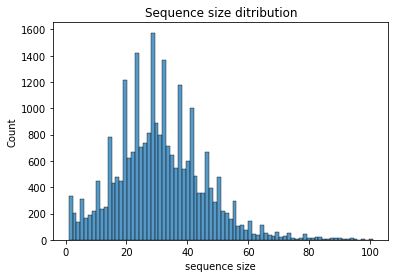

In [579]:
seq_sizes = df.groupby('patient_id').count().label
print(f'Found {len(seq_sizes.unique())} different sequence sizes in training set')

fit, ax = plt.subplots(1,1)
sns.histplot(seq_sizes, ax=ax)
ax.set_title("Sequence size ditribution")
ax.set_xlabel('sequence size')
plt.show()

In [580]:
max_seq_size = 60
dropped_patients = len(seq_sizes[seq_sizes > max_seq_size])
print(f'Dropping {dropped_patients} patients that have sequence length larger than {max_seq_size} samples from the train set ')

Dropping 778 patients that have sequence length larger than 60 samples from the train set 


# Rescaling the measurements to 0,1 using min-max scaler

In [581]:
scaler = MinMaxScaler()
measurements_label = ['measurement_x','measurement_y','measurement_z']
df[measurements_label] = scaler.fit_transform(df[measurements_label])

# Handling missing values

In [582]:
# handle missing values by replacing them with the value -1
df.fillna(-1, inplace=True)

df.head(10)

,patient_id,measurement_x,measurement_y,measurement_z,label
0,0,-1.000000,0.415782,0.151501,1
1,0,-1.000000,0.412720,0.161620,1
2,0,-1.000000,0.409647,0.160912,1
3,0,-1.000000,0.406562,0.164218,1
4,0,-1.000000,0.403466,0.167713,1
5,0,0.561678,0.400360,0.174698,1
6,0,0.560682,0.397244,0.168492,1
7,0,0.559718,0.394117,0.170168,1
8,0,0.558787,0.390981,0.167943,1
9,0,0.557889,0.387835,0.172653,1


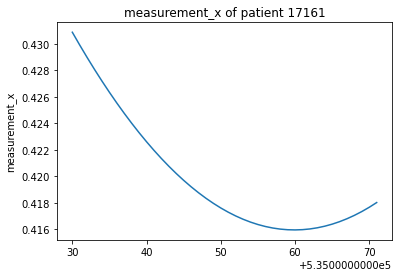

In [583]:
# rand_pat = df[df.patient_id == np.random.choice(df['patient_id'])]

sns.lineplot(data=rand_pat.measurement_x)
plt.title(f'measurement_x of patient {int(rand_pat.iloc[0].patient_id)}')
plt.show()

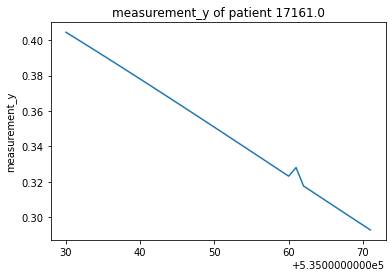

In [584]:
sns.lineplot(data=rand_pat.measurement_y)
plt.title(f'measurement_y of patient {rand_pat.iloc[0].patient_id}')
plt.show()

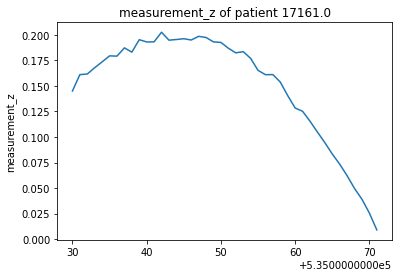

In [585]:
sns.lineplot(data=rand_pat.measurement_z)
plt.title(f'measurement_z of patient {rand_pat.iloc[0].patient_id}')
plt.show()

# Feature engineering and zero padding to each measurement

In [612]:
lst = []
for pat in df.patient_id.unique():
    temp_df = df[df.patient_id == pat].drop(columns='patient_id').copy()
    label = temp_df['label'].iloc[0]
    temp_df = np.asarray(temp_df).reshape((1,) + temp_df.shape)
    n = temp_df.shape[1]
    if n < max_seq_size:
        completion = np.zeros(shape=(1,max_seq_size-n,4))
        completion[:,:,3] = label
        temp_df = np.concatenate([temp_df, completion], axis=1)
    else:
        temp_df = temp_df[:,:max_seq_size,:]
    
    lst.append(temp_df)
    
X = np.concatenate(lst, axis=0)

print("Example of a single record in new processed data:")
print(X[0])

Example of a single record in new processed data:
[[-1.          0.41578166  0.15150074  1.        ]
 [-1.          0.41271991  0.16162014  1.        ]
 [-1.          0.40964655  0.16091186  1.        ]
 [-1.          0.40656189  0.16421779  1.        ]
 [-1.          0.40346628  0.16771331  1.        ]
 [ 0.56167809  0.40036004  0.17469752  1.        ]
 [ 0.56068203  0.3972435   0.16849195  1.        ]
 [ 0.55971837  0.39411698  0.17016793  1.        ]
 [ 0.55878721  0.39098083  0.16794289  1.        ]
 [ 0.55788865  0.38783535  0.17265267  1.        ]
 [ 0.55702278  0.3846809   0.16793156  1.        ]
 [ 0.5561897   0.3815178   0.16706823  1.        ]
 [ 0.5553895   0.37834639  0.16816357  1.        ]
 [ 0.55462225  0.375167    0.15873504  1.        ]
 [ 0.55388805  0.37197997  0.15672289  1.        ]
 [ 0.55318696  0.36878564  0.15523757  1.        ]
 [ 0.55251906  0.36558433  0.14842509  1.        ]
 [ 0.55188443  0.3623764   0.14517633  1.        ]
 [ 0.55128313  0.35916218  0.141

# Train-Validation split

In [621]:
X_train, X_cv, y_train, y_cv = train_test_split(X, df.drop_duplicates(subset=['patient_id'])['label'], test_size=0.25, random_state=7)
print('train set size:', X_train.shape)
print('test set size:', X_cv.shape)

train set size: (19279, 60, 4)
test set size: (6427, 60, 4)


# Model Architecture - LSTM

In [636]:
model = Sequential()
model.add(LSTM(max_seq_size))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_cv, y_cv), epochs=10, batch_size=64)
print(model.summary())

Epoch 1/10
302/302 [==============================] - 11s 33ms/step - loss: 0.0000e+00 - accuracy: 0.9047 - val_loss: 0.0000e+00 - val_accuracy: 0.9292
Epoch 2/10
302/302 [==============================] - 10s 32ms/step - loss: 0.0000e+00 - accuracy: 0.9267 - val_loss: 0.0000e+00 - val_accuracy: 0.9292
Epoch 3/10
302/302 [==============================] - 9s 31ms/step - loss: 0.0000e+00 - accuracy: 0.9252 - val_loss: 0.0000e+00 - val_accuracy: 0.9292
Epoch 4/10
302/302 [==============================] - 9s 30ms/step - loss: 0.0000e+00 - accuracy: 0.9250 - val_loss: 0.0000e+00 - val_accuracy: 0.9292
Epoch 5/10
302/302 [==============================] - 10s 32ms/step - loss: 0.0000e+00 - accuracy: 0.9248 - val_loss: 0.0000e+00 - val_accuracy: 0.9292
Epoch 6/10
302/302 [==============================] - 10s 34ms/step - loss: 0.0000e+00 - accuracy: 0.9271 - val_loss: 0.0000e+00 - val_accuracy: 0.9292
Epoch 7/10
302/302 [==============================] - 12s 38ms/step - loss: 0.0000e+00 - a

# Evaluation of the model

In [638]:
scores = model.evaluate(X_cv, y_cv, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 92.92%


In [679]:
import warnings
warnings.filterwarnings('always')

y_pred = model.predict_classes(X_cv).reshape(-1)
display(classification_report(y_true=y_cv.values, y_pred=y_pred, labels=[0,1,2], output_dict=True, zero_division=1))

/home/gil/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/gil/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


{'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 4412},
 '1': {'precision': 0.7741935483870968,
  'recall': 1.0,
  'f1-score': 0.8727272727272727,
  'support': 1560},
 '2': {'precision': 1.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 455},
 'accuracy': 0.9292049167574296,
 'macro avg': {'precision': 0.924731182795699,
  'recall': 0.6666666666666666,
  'f1-score': 0.6242424242424242,
  'support': 6427},
 'weighted avg': {'precision': 0.9451909032960746,
  'recall': 0.9292049167574296,
  'f1-score': 0.8983125167970353,
  'support': 6427}}